<a href="https://colab.research.google.com/github/smf-9000/Text-Intent-Classification/blob/main/TextClassificationSimpleBERTExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
Sentiment analysis, example from huggingface.org
[https://huggingface.co/transformers/custom_datasets.html]
```



In [2]:
! wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
! tar -xf aclImdb_v1.tar.gz
# This data is organized into pos and neg folders with one text file per example.

--2021-07-05 10:21:31--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  20.7MB/s    in 5.1s    

2021-07-05 10:21:36 (15.8 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
! pip install pandas transformers

In [4]:
from pathlib import Path

In [6]:
def read_imdb_split(split_dir):
  split_dir = Path(split_dir)
  texts = []
  labels = []
  for label_dir in ["pos", "neg"]:
    for text_file in (split_dir/label_dir).iterdir():
      texts.append(text_file.read_text())
      labels.append(0 if label_dir is "neg" else 1)
      # labels can have more than two classes !!! [Adapt]
  return texts, labels

In [7]:
train_texts, train_labels = read_imdb_split('aclImdb/train')
test_texts, test_labels = read_imdb_split('aclImdb/test')

In [ ]:
print(test_labels[0])

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# Let's split train dataset to get validation dataset also
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [15]:
# train_texts, train_labels
# val_texts, val_labels
# test_texts, test_labels
print('train: ', len(train_labels))
print('val: ', len(val_labels))
print('test: ', len(test_labels))

train:  12800
val:  3200
test:  25000




```
---Create train and validation encodings---
```



In [18]:
# I will train a classifier using pre-trained DistilBert.
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [76]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)
# I added max_length to speed up training.

In [20]:
import torch

In [23]:
# "Now, let’s turn our labels and encodings into a Dataset object. In PyTorch, 
# this is done by subclassing a torch.utils.data.Dataset object and 
# implementing __len__ and __getitem__. We put the data in this format so that
# the data can be easily batched such that each key in the batch encoding
# corresponds to a named parameter of the forward() method of the model we will train."

class IMDbDataset(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings = encodings
    self.labels = labels

  def __getitem__(self, idx):
    item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    item['labels'] = torch.tensor(self.labels[idx])
    return item

  def __len__(self):
    return len(self.labels)

# Ok, "Trainer" expected datasets in this format, so we won't complain. It seems straightforward.

In [77]:
train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

## Fine-tuning with Trainer

In [79]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels = 2)
# In case we want to freeze the pretrained part of a BertForSequenceClassification model:
# for param in model.base_model.parameters():
#     param.requires_grad = False

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.d423bdf2f58dc8b77d5f5d18028d7ae4a72dcfd8f468e81fe979ada957a8c361
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,

In [ ]:
trainer = Trainer(
  model=model,                         # the instantiated 🤗 Transformers model to be trained
  args=training_args,                  # training arguments, defined above
  train_dataset=train_dataset,         # training dataset
  eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

## Evaluation

In [ ]:
model.eval()

In [ ]:
# from sklearn.metrics import confusion_matrix, classification_report
# # test_texts, test_labels

In [81]:
model.eval()
from torch.nn import functional as F
device = "cuda:0"

def get_prediction(model, text):
  with torch.no_grad():
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256).to(device)

    outputs = model(**inputs) # output_hidden_states=True
    softmax = F.softmax(outputs[0], dim = 1)
    # print(softmax)
    index = softmax[0].argmax().item()
  return index

In [ ]:
# 0 if label_dir is "neg" else 1

_true = 0
_false = 0
test_pred = []
for i in range(len(test_labels)):
  pred = get_prediction(model, test_texts[i])
  test_pred.append(pred)
  if pred == test_labels[i]:
    _true += 1
  else:
    _false += 1
    print(test_labels[i], '-', test_texts[i])
  if i%1000 == 0:
    print(i, '-----------')

print(_true, _false)



In [90]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

class_names = ['negative', 'positive']
print(classification_report(test_labels, test_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.92      0.89      0.90     12500
    positive       0.89      0.92      0.91     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



[[11070  1430]
 [  965 11535]]


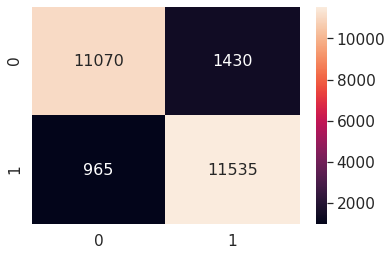

In [102]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

c_matrix = confusion_matrix(test_labels, test_pred, labels=[0, 1])
print(c_matrix)

df_cm = pd.DataFrame(c_matrix, range(2), range(2))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size

plt.show()



```
Test:
[128 max_length, 3 epochs] correct: 21694 wrong: 3306
[256 max_length, 3 epochs] correct: 22605  wrong: 2395
```

